<a href="https://colab.research.google.com/github/akhilsrinath/medical-transcription-classification/blob/main/medical_transcription_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset**

The dataset contains sample medical transcriptions for various medical specialties.

This data was scraped from mtsamples.com. 

Link: https://www.kaggle.com/tboyle10/medicaltranscriptions 



### **Problem statement**

Can we build a classification model that can classify each medical transciption to its specific speciality?



#### Importing libraries 

In [7]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [85]:
import spacy 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import string 
import re 


from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE


In [9]:
def count_sentence_word(text_list):
  """Counts the number of words and sentences in a list of text"""
  sent_count = 0
  word_count = 0 
  vocab = {}
  for text in tqdm_notebook(text_list):
    sentences = sent_tokenize(str(text).lower())
    sent_count = sent_count + len(sentences)
    for sentence in sentences:
      words = word_tokenize(sentence)
      for word in words:
        if (word in vocab.keys()):
          vocab[word] = vocab[word] + 1
        else:
          vocab[word] = 1
  
  word_count = len(vocab.keys())
  return sent_count, word_count


In [10]:
t = ['Hello my name is akhil', 'I like reading books', 'My name is lil', 'I enjoy playing the guitar']


In [11]:
count_sentence_word(t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4 [00:00<?, ?it/s]

(4, 14)

#### **EDA**

In [12]:
df = pd.read_csv('/content/mtsamples.csv')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [13]:
df['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [14]:
len(list(df['medical_specialty'].value_counts()))

40

In [15]:
## Check for missing values 

df.isnull().any()

Unnamed: 0           False
description          False
medical_specialty    False
sample_name          False
transcription         True
keywords              True
dtype: bool

In [16]:
df.isnull().sum()

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [17]:
len(df)

4999

- We have 40 unique medical specialities
- There are about 5000 records in total 
- There are 33 records with no transcriptions. We can drop these rows. 

In [18]:
df.dropna(subset=['transcription'], inplace=True)

In [19]:
len(df)

4966

In [20]:
sent_count, word_count = count_sentence_word(df['transcription'].to_list())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4966 [00:00<?, ?it/s]

In [21]:
sent_count

140214

In [22]:
df['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

We see that most there are several specialities that have comparatively very few records. We can filter the dataframe to contain only those specialities that have at least 50 or more records. 

In [23]:
## Filtering out the dataset to contain only those specialties with more than 50 records 

df = df.groupby('medical_specialty').filter(lambda x: len(x) > 50)
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."
11,11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler..."


In [24]:
df['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
Name: medical_specialty, dtype: int64

We now notice that the total number of specialties reduces from 40 to 21.

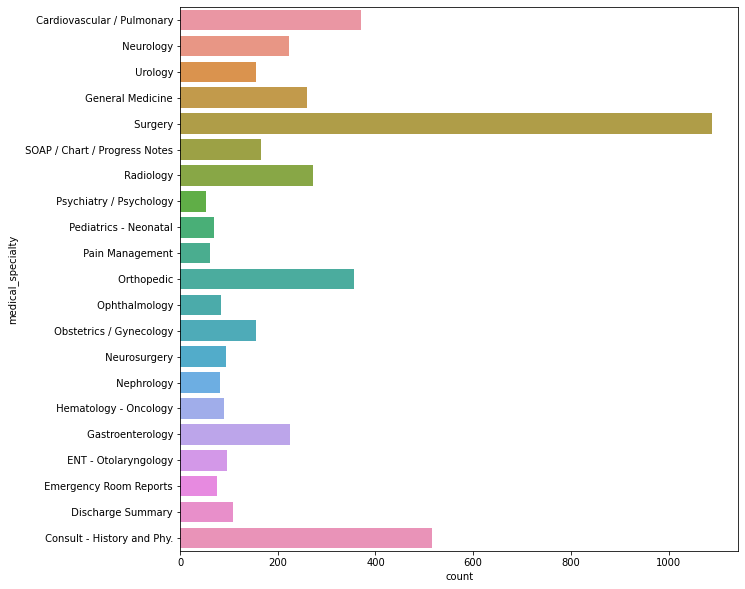

In [25]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data=df)
plt.show()

#### **Data Preprocessing**

Filtering out just the transcription and the associated label for the specialty. 

In [26]:
data = df[['transcription', 'medical_specialty']]
data.head()

,transcription,medical_specialty
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary


In [27]:
len(data)

4597

Sample transcription:

In [28]:
data.iloc[5]['transcription']

'CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETOH.,ROS:, Irregular menses.,EXAM:

In [29]:
data.iloc[120]['transcription']

'PREOPERATIVE DIAGNOSIS: , Recurrent bladder tumors.,POSTOPERATIVE DIAGNOSIS:,  Recurrent bladder tumors.,OPERATION: , Cystoscopy, TUR, and electrofulguration of recurrent bladder tumors.,ANESTHESIA:,  General.,INDICATIONS: , A 79-year-old woman with recurrent bladder tumors of the bladder neck.,DESCRIPTION OF PROCEDURE:  ,The patient was brought to the operating room, prepped and draped in lithotomy position under satisfactory general anesthesia.  A #21-French cystourethroscope was inserted into the bladder.  Examination of the bladder showed approximately a 3-cm area of erythema and recurrent papillomatosis just above and lateral to the left ureteral orifice.  No other lesions were noted.  Using a cold punch biopsy forceps, a random biopsy was obtained.  The entire area was electrofulgurated using the Bugbee electrode.  The patient tolerated the procedure well and left the operating room in satisfactory condition.'

In [75]:
def clean_text(text): 

  text = text.translate(str.maketrans('', '', string.punctuation))
  text1 = ''.join([w for w in text if not w.isdigit()]) 
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
  
  text2 = text1.lower()
  text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
  #text2 = BAD_SYMBOLS_RE.sub('', text2)
  return text2

In [76]:
## Testing 

t = "Hello my name is #$% and my A-number is 1234432!!!"
t2 = clean_text(t)
t2

'hello my name is  and my anumber is '

In [82]:
def lemmatizer(text):
  wordlist=[]
  lemmatizer = WordNetLemmatizer() 
  sentences=sent_tokenize(text)
    
  intial_sentences= sentences[0:1]
  final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
  for sentence in intial_sentences:
      words=word_tokenize(sentence)
      for word in words:
          wordlist.append(lemmatizer.lemmatize(word))
  for sentence in final_sentences:
      words=word_tokenize(sentence)
      for word in words:
          wordlist.append(lemmatizer.lemmatize(word))       
  return ' '.join(wordlist)  

Applying these two functions to clean the text:

In [83]:
data['transcription'] = data['transcription'].apply(lemmatizer)
data['transcription'] = data['transcription'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### **TF-IDF Matrix**

In [86]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1,3), max_df=0.75, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abnormality', 'abscess', 'activity', 'acute', 'additional', 'adenocarcinoma', 'adequate', 'administered', 'admission', 'admission diagnosis', 'admitted', 'admitting', 'admitting diagnosis', 'africanamerican', 'age', 'ago', 'airway', 'alcohol', 'allergy', 'alternative', 'anemia', 'anesthesia', 'anesthesia care', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthetic', 'angina', 'angiography', 'ankle', 'anterior', 'antibiotic', 'aortic', 'apnea', 'apparent', 'appendicitis', 'applied', 'appointment', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'arthroplasty', 'asked', 'aspect', 'aspiration', 'assessment', 'associated', 'atrial', 'atrial fibrillation', 'awakened', 'axial', 'axial ct', 'axial ct image', 'axis', 'baby', 'base', 'benefit', 'benign', 'better', 'bid', 'bilateral', 'bilaterally', 'biopsy', 'bladder', 'bladder tumor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [87]:
len(feature_names)

1000

In [ ]:
import gc 
gc.collect()
tfI